In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import butter, filtfilt
from datetime import datetime

In [2]:
df = pd.read_csv('Subject_4\CSV\BrainFlow-RAW_2023-03-07_11-46-58_44.csv', delimiter='\t')

In [3]:
df = df.loc[6:,:]

data = df.iloc[:,1:3]
time = df.iloc[:, -2]

In [4]:
data

,12941.391819,5478.546676
6,14058.219082,6950.364345
7,14050.954765,6953.493590
8,14052.541739,6952.398354
9,14057.146198,6943.859988
10,14056.207425,6937.825017
...,...,...
17959,14593.588065,7783.838544
17960,14592.246961,7778.697643
17961,14582.926283,7780.038748
17962,14585.563789,7800.132966


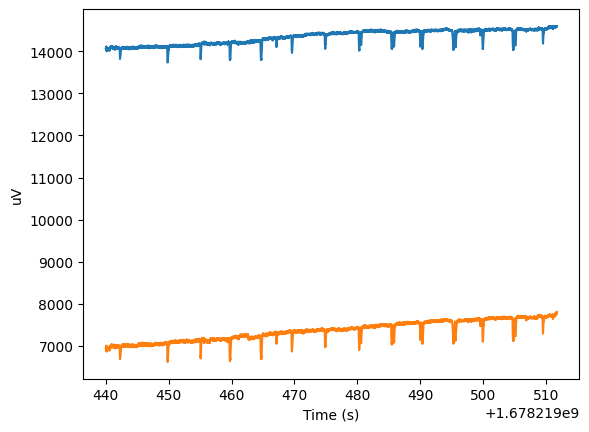

In [5]:
plt.plot(time, data);
plt.xlabel('Time (s)');
plt.ylabel('uV');

In [6]:
# Define the cutoff frequency (in Hz) for the high pass filter
cutoff_freq = 1

# Define the filter order
filter_order = 8

# Define the sampling rate (in Hz) for the voltage data
sampling_rate = 250

# Define the time variable
#time = data.iloc[:, 0].values

# Define the voltage variable
voltage_chan_1 = data.iloc[:, 0].values
voltage_chan_2 = data.iloc[:, 1].values

# Define the filter coefficients
nyquist_freq = sampling_rate / 2
normalized_cutoff_freq = cutoff_freq / nyquist_freq
b, a = butter(filter_order, normalized_cutoff_freq, btype='highpass')

# Apply the filter to the voltage data
filtered_voltage_chan_1 = filtfilt(b, a, voltage_chan_1)
filtered_voltage_chan_2 = filtfilt(b, a, voltage_chan_2)

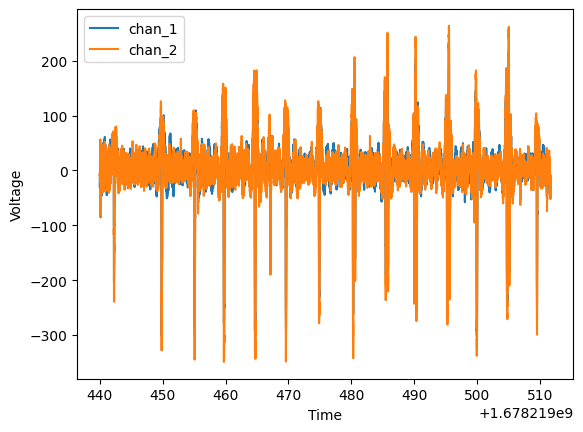

In [7]:
plt.plot(time, filtered_voltage_chan_1, label='chan_1')
plt.plot(time, filtered_voltage_chan_2, label='chan_2')
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.legend()
plt.show()

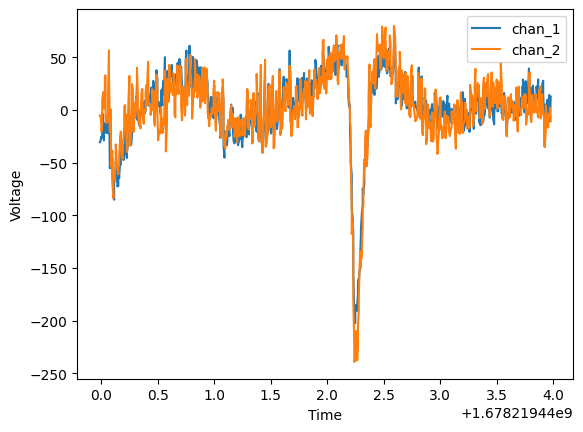

In [8]:
plt.plot(time[1:1000], filtered_voltage_chan_1[1:1000], label='chan_1')
plt.plot(time[1:1000], filtered_voltage_chan_2[1:1000], label='chan_2')
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.legend()
plt.show()

In [9]:
# Define the cutoff frequency (in Hz) for the low pass filter
cutoff_freq = 5

# Define the filter order
filter_order = 8

# Define the sampling rate (in Hz) for the voltage data
sampling_rate = 250

# Define the filter coefficients
nyquist_freq = sampling_rate / 2
normalized_cutoff_freq = cutoff_freq / nyquist_freq
b, a = butter(filter_order, normalized_cutoff_freq, btype='lowpass')

# Apply the filter to the voltage data
filtered_voltage_chan_1 = filtfilt(b, a, filtered_voltage_chan_1)
filtered_voltage_chan_2 = filtfilt(b, a, filtered_voltage_chan_2)

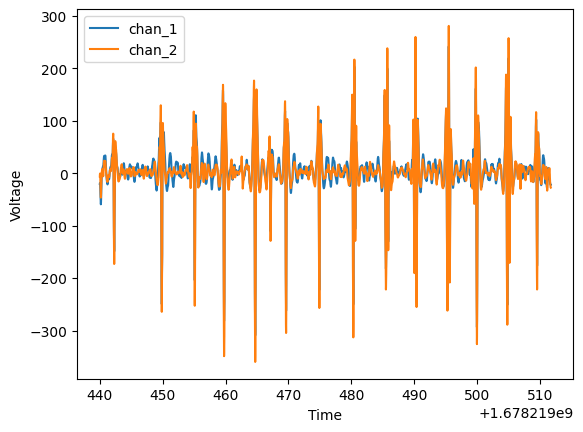

In [10]:
plt.plot(time, filtered_voltage_chan_1, label='chan_1')
plt.plot(time, filtered_voltage_chan_2, label='chan_2')
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.legend()
plt.show()


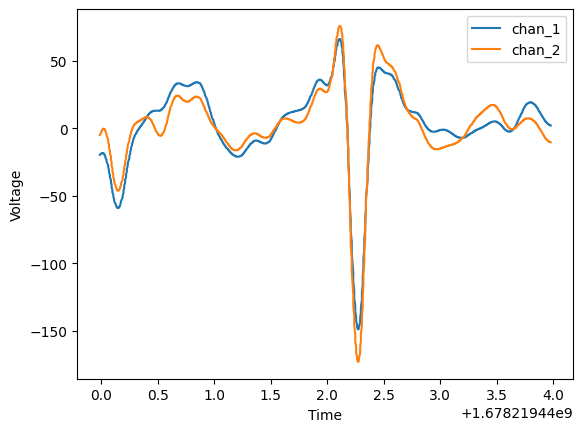

In [11]:
plt.plot(time[1:1000], filtered_voltage_chan_1[1:1000], label='chan_1')
plt.plot(time[1:1000], filtered_voltage_chan_2[1:1000], label='chan_2')
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.legend()
plt.show()

In [12]:
def average_min_max(data, time):  
    min, max, num_min, num_max = 0, 0, 0, 0
    for i in range(len(time)):
        if (data[i] <= -100):
            min += data[i]
            num_min += 1
        elif (data[i] >= 70):
            max += data[i]
            num_max += 1
    min /= num_min
    max /= num_max
    return min, max

In [13]:
avg_min, avg_max = average_min_max(filtered_voltage_chan_1, time)  
avg_min, avg_max

(-179.33903068390757, 108.69517190996692)

In [16]:
def svt(data, time):
    return

filtered_voltage_chan_1

array([-20.29933524, -19.80367406, -19.36234183, ..., -21.94234413,
       -21.96469273, -21.9828423 ])